In [ ]:
import os
import json
import pandas as pd

def extract_data_from_json(json_file):
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    image_info = data["image"][0]
    image_id = image_info["id"]
    file_name = image_info["file_name"]
    image_width = data["metadata"]["width"]  # 이미지 너비
    image_height = data["metadata"]["height"]  # 이미지 높이

    annotations = data["annotations"]
    annotation_data = []

    for annotation in annotations:
        category_id = annotation["category_id"]
        bbox = annotation.get("bbox")  # 바운딩 박스
        polygon = annotation.get("polygon", [])
        status = annotation["status"]

        if bbox:  # 바운딩 박스가 주어진 경우
            # 바운딩 박스 좌표 (x_min, y_min, width, height)에서 (x_min, y_min, x_max, y_max) 형태로 변환
            xmin, ymin, width, height = bbox
            xmax = xmin + width
            ymax = ymin + height

        else:  # 바운딩 박스가 주어지지 않은 경우
            xmin, ymin, xmax, ymax = 0, 0, 0, 0

        annotation_data.append({
            "image_id": image_id,
            "category_id": category_id,
            "bbox": [xmin, ymin, xmax, ymax],
            "polygon": polygon,
            "status": status,
            "file_name": file_name
        })

    return annotation_data

def create_dataframe_from_folder(folder):
    json_files = [f for f in os.listdir(folder) if f.endswith('.json')]
    all_data = []
    for json_file in json_files:
        json_path = os.path.join(folder, json_file)
        data = extract_data_from_json(json_path)
        all_data.extend(data)
    return pd.DataFrame(all_data)


In [ ]:
folder1 = "/content/drive/MyDrive/DL/project/Teamproject/TL_일반철도_정상"
folder2 = "/content/drive/MyDrive/DL/project/Teamproject/TL_일반철도_이상"

df1 = create_dataframe_from_folder(folder1)
df2 = create_dataframe_from_folder(folder2)

all_data = pd.concat([df1, df2], ignore_index=True)

df = all_data.drop(all_data[all_data['category_id'] == 12].index) #bbox 정보 없는 [12:rail] drop
df.drop('polygon', axis=1, inplace=True) #polygon 사용 X

df['status'] = df['status'].map({'normal': 0, 'abnormal': 1}) #정상/이상 여부 0,1로 변경
df['category_id'] -= 13 #category_id 13~18 라벨 값을 0~5로 변경

In [ ]:
import numpy as np

# 바운딩 박스 좌표를 개별 열로 추출
df[['xmin', 'ymin', 'xmax', 'ymax']] = pd.DataFrame(df['bbox'].tolist(), index=df.index)
df.drop(columns=['bbox'], inplace=True)

# 바운딩 박스 좌표가 float 타입인지 확인
df[['xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype(float)

# 바운딩 박스를 확인하고 수정하세요.
def verify_and_correct_boxes(dataframe):
    dataframe = dataframe.copy()
    invalid_boxes = dataframe[(dataframe['xmax'] <= dataframe['xmin']) | (dataframe['ymax'] <= dataframe['ymin'])]
    if not invalid_boxes.empty:
        dataframe = dataframe.drop(invalid_boxes.index)
    return dataframe

df = verify_and_correct_boxes(df)

In [ ]:
# 지정 폴더 경로
IMG_PATH = '/content/drive/MyDrive/DL/project/Teamproject/원천_folder'

# 파일 존재 여부 확인 함수
def file_exists(file_name):
    return os.path.isfile(os.path.join(IMG_PATH, file_name))

# 파일이 존재하는 행만 남기기
df = df[df['file_name'].apply(file_exists)].reset_index(drop=True)

df.reset_index(drop=True, inplace=True) #index 정리

display(df.head())
print(df.shape)

image_ids = df['image_id'].unique()
print(len(image_ids))

,image_id,category_id,status,file_name,xmin,ymin,xmax,ymax
0,3367107,3,0,일반철도_220826_반석역2_3367107.jpg,0.0,0.0,31.0,24.0
1,3367107,3,0,일반철도_220826_반석역2_3367107.jpg,0.0,439.0,26.0,484.0
2,3367107,3,0,일반철도_220826_반석역2_3367107.jpg,0.0,627.0,39.0,703.0
3,3367107,2,0,일반철도_220826_반석역2_3367107.jpg,0.0,713.0,31.0,799.0
4,3367107,3,0,일반철도_220826_반석역2_3367107.jpg,825.0,591.0,979.0,659.0


(34684, 8)
3627


In [ ]:
from sklearn.model_selection import train_test_split

# 고유한 이미지 ID 가져오기
image_ids = df['image_id'].unique()

# 데이터를 8:2 비율로 train+valid와 test로 분할
train_valid_ids, test_ids = train_test_split(image_ids, test_size=0.1, random_state=42)

# 남은 데이터에서 train+valid를 8:1 비율로 train과 valid로 분할
train_ids, valid_ids = train_test_split(train_valid_ids, test_size=0.1, random_state=42)  # 0.1111 * 0.9 ≈ 원래 데이터셋의 0.1

# 해당하는 데이터프레임 생성
train_df = df[df['image_id'].isin(train_ids)]
valid_df = df[df['image_id'].isin(valid_ids)]
test_df = df[df['image_id'].isin(test_ids)]

# 결과 데이터프레임의 모양 출력
print(train_df.shape, valid_df.shape, test_df.shape)


(27868, 8) (3407, 8) (3409, 8)


In [ ]:
import utils
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

class RailroadDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index):
        record = self.dataframe.iloc[index]
        file_name = record['file_name']
        image_path = os.path.join(self.image_dir, file_name)
        image = cv2.imread(image_path)

        if image is None:
            return None  # 이미지 파일이 없을 경우 None 반환

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        boxes = np.array([record[['xmin', 'ymin', 'xmax', 'ymax']].values], dtype=np.float32)
        labels = np.array([record['category_id']], dtype=np.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = np.zeros((len(boxes),), dtype=np.int64)

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([index]),
            'area': torch.tensor(area, dtype=torch.float32),
            'iscrowd': torch.tensor(iscrowd, dtype=torch.int64)
        }

        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)
        return image, target

    def __len__(self):
        return len(self.dataframe)

In [ ]:
# train 및 validation 데이터프레임에서 박스를 검증하고 수정
train_df = verify_and_correct_boxes(train_df)
valid_df = verify_and_correct_boxes(valid_df)

# train 및 validation 하위 집합의 샘플 수
num_train_samples = 10000
num_valid_samples = 1000

# train 및 validation 인덱스
train_indices = list(range(num_train_samples))
valid_indices = list(range(num_valid_samples))

# 하위 데이터셋
train_subset = Subset(RailroadDataset(train_df, IMG_PATH), train_indices)
valid_subset = Subset(RailroadDataset(valid_df, IMG_PATH), valid_indices)

# 데이터 로더
num_workers = min(4, torch.get_num_threads())

# 누락된 이미지를 처리하기 위한 사용자 정의 collate 함수 정의
def my_collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # None 값을 제거
    if len(batch) == 0:
        return torch.Tensor(), {}  # 모든 항목이 None인 경우 빈 텐서를 반환
    return tuple(zip(*batch))

# train 데이터 로더
train_data_loader = DataLoader(
    train_subset,
    batch_size=5,
    shuffle=True,
    num_workers=num_workers,
    collate_fn=my_collate_fn
)

# validation 데이터 로더
valid_data_loader = DataLoader(
    valid_subset,
    batch_size=5,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=my_collate_fn
)


## 바운딩 박스 예시 이미지 출력

Image path: /content/drive/MyDrive/DL/project/Teamproject/일반철도_원천/일반철도_220826_반석역2_3366708.jpg


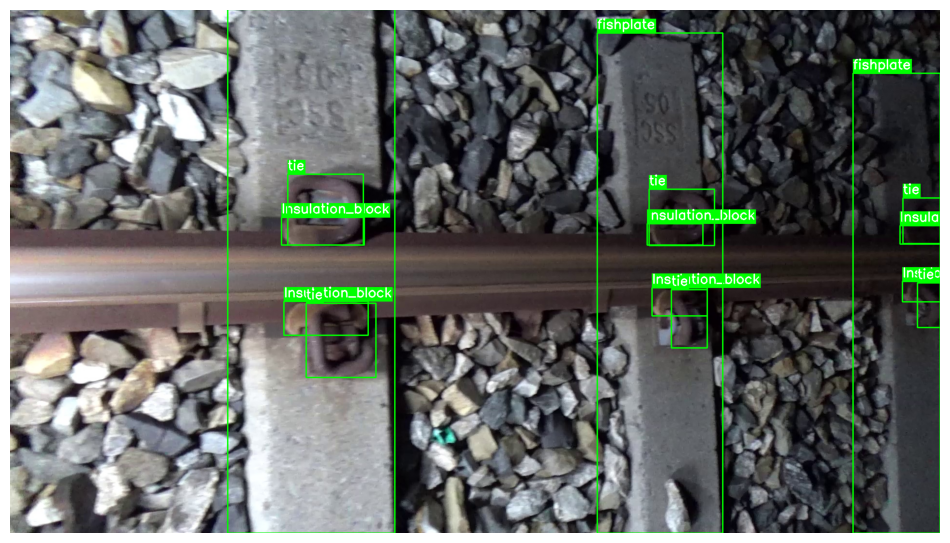

In [ ]:
import matplotlib.pyplot as plt

# 라벨 클래스 이름
class_names = {
    0: 'pandrol_e-clip',
    1: 'bolt-nut',
    2: 'tie',
    3: 'Insulation_block',
    4: 'screw_spike',
    5: 'fishplate'
}

# 바운딩 박스와 라벨을 이미지에 그리는 함수
def plot_image_with_bboxes(image_path, bboxes, labels, statuses):
    print(f"Image path: {image_path}")

    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    image = cv2.imread(image_path)

    if image is None:
        print(f"Failed to read image: {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for bbox, label, status in zip(bboxes, labels, statuses):
        xmin, ymin, xmax, ymax = bbox
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

        color = (0, 255, 0) if status == 0 else (255, 0, 0)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        label_name = class_names[label]

        (text_width, text_height), baseline = cv2.getTextSize(label_name, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)
        cv2.rectangle(image, (xmin, ymin - text_height - baseline), (xmin + text_width, ymin), color, -1)
        cv2.putText(image, label_name, (xmin, ymin - baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 1번 train data의 이미지와 바운딩 박스 가져오기
first_train_image_id = train_df['image_id'].iloc[0]
first_train_file_name = train_df[train_df['image_id'] == first_train_image_id]['file_name'].values[0]
first_train_bboxes = train_df[train_df['image_id'] == first_train_image_id][['xmin', 'ymin', 'xmax', 'ymax']].values
first_train_labels = train_df[train_df['image_id'] == first_train_image_id]['category_id'].values
first_train_statuses = train_df[train_df['image_id'] == first_train_image_id]['status'].values

# 이미지 경로
image_path = os.path.join(IMG_PATH, first_train_file_name)

# 바운딩 박스 그리기
plot_image_with_bboxes(image_path, first_train_bboxes, first_train_labels, first_train_statuses)